# Mean Reversion Strategy

## Importing Data
### Stock: NVDA \ Period: 1Y, Interval: 1D

In [26]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

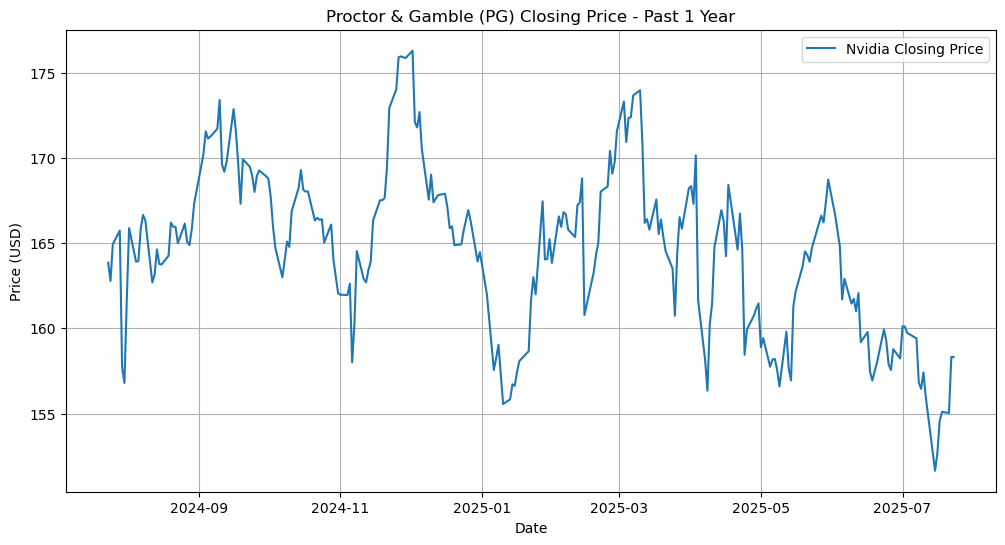

In [44]:
pg = yf.Ticker("PG")

data = pg.history(period = "1y", interval = "1d")

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Nvidia Closing Price')
plt.title('Proctor & Gamble (PG) Closing Price - Past 1 Year')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# mean reversion doesn't work well with high growth stocks


## Strategy Implementation
### Buy then the short-term MA is lower than the long-term MA, sell when opposite

In [51]:
# for reference
print(data.head(3))

                                 Open        High         Low       Close  \
Date                                                                        
2024-07-22 00:00:00-04:00  120.311989  124.030816  119.822146  123.500984   
2024-07-23 00:00:00-04:00  122.741227  124.650628  122.061442  122.551285   
2024-07-24 00:00:00-04:00  119.132357  119.912110  113.404171  114.213913   

                              Volume  Dividends  Stock Splits  
Date                                                           
2024-07-22 00:00:00-04:00  258068900        0.0           0.0  
2024-07-23 00:00:00-04:00  173911000        0.0           0.0  
2024-07-24 00:00:00-04:00  327776900        0.0           0.0  


### Use the first 30 days to get an average

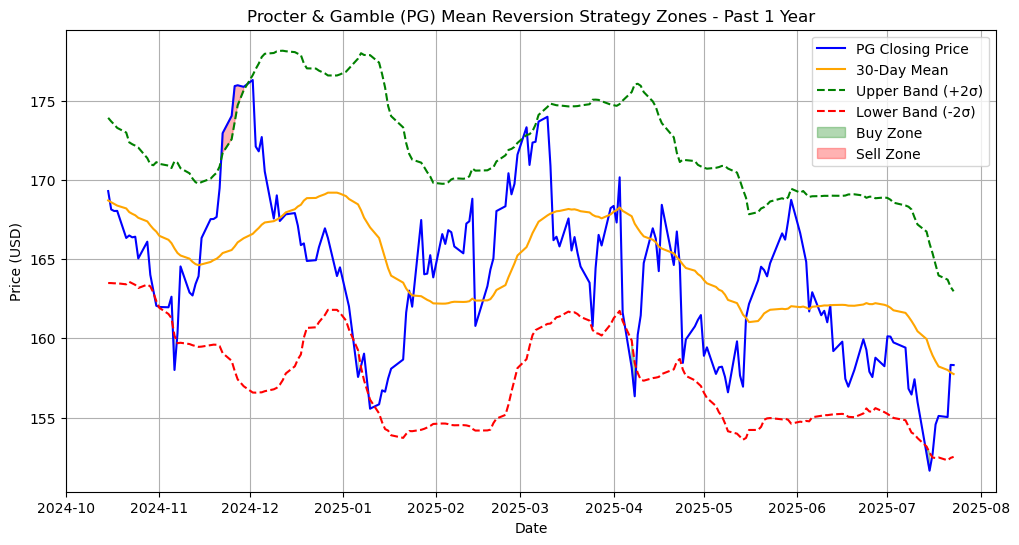

Total net profit from mean reversion strategy: $24.11


In [57]:
# Calculate rolling mean and std deviation
data['30d_mean'] = data['Close'].rolling(window=30).mean()
data['30d_std'] = data['Close'].rolling(window=30).std()

# Calculate upper and lower bands
data['upper_band'] = data['30d_mean'] + 2 * data['30d_std']
data['lower_band'] = data['30d_mean'] - 2 * data['30d_std']

# Drop NaNs from rolling calculations
data = data.dropna().reset_index()

# Initialize variables for profit calc
holding = False
buy_price = 0
total_profit = 0

for i in range(1, len(data)):
    price = data.loc[i, 'Close']
    lower = data.loc[i, 'lower_band']
    mean = data.loc[i, '30d_mean']
    prev_price = data.loc[i-1, 'Close']
    prev_lower = data.loc[i-1, 'lower_band']
    prev_mean = data.loc[i-1, '30d_mean']

    if not holding:
        # Buy when price crosses below lower band
        if price < lower and prev_price >= prev_lower:
            holding = True
            buy_price = price
    else:
        # Sell when price crosses above mean
        if price > mean and prev_price <= prev_mean:
            holding = False
            total_profit += price - buy_price

# Sell at last price if still holding
if holding:
    total_profit += data.loc[len(data)-1, 'Close'] - buy_price

# Plot price and bands
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='PG Closing Price', color='blue')
plt.plot(data['Date'], data['30d_mean'], label='30-Day Mean', color='orange')
plt.plot(data['Date'], data['upper_band'], label='Upper Band (+2σ)', color='green', linestyle='--')
plt.plot(data['Date'], data['lower_band'], label='Lower Band (-2σ)', color='red', linestyle='--')

# Shade buy zone (price below lower band)
plt.fill_between(data['Date'], data['Close'], data['lower_band'],
                 where=(data['Close'] < data['lower_band']),
                 color='green', alpha=0.3, label='Buy Zone')

# Shade sell zone (price above upper band)
plt.fill_between(data['Date'], data['Close'], data['upper_band'],
                 where=(data['Close'] > data['upper_band']),
                 color='red', alpha=0.3, label='Sell Zone')

plt.title('Procter & Gamble (PG) Mean Reversion Strategy Zones - Past 1 Year')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Total net profit from mean reversion strategy: ${total_profit:.2f}")

### Iterate continuously to find an optimal sigma and mean range for this time frame

In [68]:
raw_data = pg.history(period="1y", interval="1d").copy()

sigma_values = np.arange(0.1, 2.1, 0.1)
mean_windows = range(5, 61)

best_profit = float('-inf')
best_params = (None, None)

shares = 100  # number of shares per trade

for window in mean_windows:
    data = raw_data.copy()
    data['rolling_mean'] = data['Close'].rolling(window=window).mean()
    data['rolling_std'] = data['Close'].rolling(window=window).std()
    data = data.dropna().reset_index()

    for sigma in sigma_values:
        data['upper_band'] = data['rolling_mean'] + sigma * data['rolling_std']
        data['lower_band'] = data['rolling_mean'] - sigma * data['rolling_std']

        holding = False
        buy_price = 0
        total_profit = 0

        for i in range(1, len(data)):
            price = data.loc[i, 'Close']
            lower = data.loc[i, 'lower_band']
            mean = data.loc[i, 'rolling_mean']
            prev_price = data.loc[i - 1, 'Close']
            prev_lower = data.loc[i - 1, 'lower_band']
            prev_mean = data.loc[i - 1, 'rolling_mean']

            if not holding:
                if price < lower and prev_price >= prev_lower:
                    holding = True
                    buy_price = price
            else:
                if price > mean and prev_price <= prev_mean:
                    holding = False
                    total_profit += (price - buy_price) * shares

        if holding:
            total_profit += (data.loc[len(data) - 1, 'Close'] - buy_price) * shares

        if total_profit > best_profit:
            best_profit = total_profit
            best_params = (window, round(sigma, 2))

print(f"Best profit: ${best_profit:.2f} with rolling mean window = {best_params[0]} days and sigma = {best_params[1]} (100 shares per trade)")

Best profit: $4698.27 with rolling mean window = 37 days and sigma = 1.7 (100 shares per trade)
